In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import timedelta
import joblib

In [3]:
sns.set_style('whitegrid')

In [4]:
def mae(y, yhat): return np.mean(np.abs(y - yhat))
def rmse(y, yhat): return np.sqrt(np.mean((y - yhat)**2))
def mape(y, yhat):
    denom = np.where(y==0, 1, y)
    return np.mean(np.abs((y - yhat)/denom))**100

In [5]:
def naive_last_value(history, harizon=28):
    last = history.groupby('id')['sales'].last()
    return history[['id']].drop_duplicates().merge(
        last.rename('yhat'), on='id', how='left'
    )
    
def moving_Average(history, window=28, horizon=28):
    ma = (history.groupby('id')['sales']
            .apply(lambda s: s.tail(window).mean())
            .rename('yhat'))
    return history[['id']].drop_duplicates().merge(ma, on='id', how='left')

def eval_baseline(df, cutoff='2016-03-27', horizon=28, method='ma'):
    train = df[df.date <= cutoff]
    test  = df[(df.date > cutoff) & (df.date <= pd.to_datetime(cutoff) + pd.Timedelta(days=horizon))]
    if method=='naive':
        preds = naive_last_value(train, horizon)
    else:
        preds = moving_average(train, window=28, horizon=horizon)

    # expand preds to all (id, date) in the horizon
    dates = pd.date_range(test.date.min(), test.date.max(), freq='D')
    grid  = (test[['id']].drop_duplicates()
                .assign(key=1).merge(pd.DataFrame({'date':dates, 'key':[1]*len(dates)}), on='key').drop('key',1))
    out = grid.merge(preds, on='id', how='left').merge(test[['id','date','sales']], on=['id','date'], how='left')
    return {
        'MAE': mae(out['sales'].values, out['yhat'].values),
        'RMSE': rmse(out['sales'].values, out['yhat'].values),
        'MAPE': mape(out['sales'].values, out['yhat'].values)
    }


In [6]:
df = pd.read_parquet('../data/processed/m5_features.parquet')
train = pd.read_parquet('../data/processed/train.parquet')
valid = pd.read_parquet('../data/processed/valid.parquet')

In [7]:
cat_cols = ['id', 'd', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']

for c in cat_cols:
    df[c] = df[c].astype('category')

In [8]:
cat_cols = ['id', 'd', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']

for c in cat_cols:
    train[c] = train[c].astype('category')

In [9]:
cat_cols = ['id', 'd', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']

for c in cat_cols:
    valid[c] = valid[c].astype('category')

In [10]:
# Remove problematic characters from column names
df.columns = df.columns.str.replace('[\[\]]', '', regex=True)
# Remove problematic characters from column names
train.columns = df.columns.str.replace('[\[\]]', '', regex=True)
# Remove problematic characters from column names
valid.columns = df.columns.str.replace('[\[\]]', '', regex=True)

<>:2: SyntaxWarning: invalid escape sequence '\['
<>:4: SyntaxWarning: invalid escape sequence '\['
<>:6: SyntaxWarning: invalid escape sequence '\['
<>:2: SyntaxWarning: invalid escape sequence '\['
<>:4: SyntaxWarning: invalid escape sequence '\['
<>:6: SyntaxWarning: invalid escape sequence '\['
C:\Users\srmpc\AppData\Local\Temp\ipykernel_42980\221503377.py:2: SyntaxWarning: invalid escape sequence '\['
  df.columns = df.columns.str.replace('[\[\]]', '', regex=True)
C:\Users\srmpc\AppData\Local\Temp\ipykernel_42980\221503377.py:4: SyntaxWarning: invalid escape sequence '\['
  train.columns = df.columns.str.replace('[\[\]]', '', regex=True)
C:\Users\srmpc\AppData\Local\Temp\ipykernel_42980\221503377.py:6: SyntaxWarning: invalid escape sequence '\['
  valid.columns = df.columns.str.replace('[\[\]]', '', regex=True)


In [11]:
train.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sales', 'date', 'wm_yr_wk', 'event_name_1', 'event_type_1',
       'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI',
       'sell_price', 'dayofweek', 'weekofyear', 'month', 'year', 'lags_1',
       'lags_7', 'lags_14', 'lags_28', 'rolling_mean_7', 'rolling_std_7',
       'rolling_mean_14', 'rolling_std_14', 'rolling_mean_28',
       'rolling_std_28', 'quarter', 'is_weekend', 'dow_sin', 'dow_cos',
       'price_max', 'price_min', 'price_norm', 'price_change', 'is_event',
       'is_snap_CA', 'is_snap_TX', 'is_snap_WI', 'lag_price_7',
       'rmean_price_28', 'sales_log1p', 'demand_volatility',
       'rolling_mean_7_lag_7_ratio'],
      dtype='object')

In [12]:
ignore = ['id', 'date', 'sales']
X_cols = [c for c in df.columns if c not in ignore]

X_tr, y_tr = train[X_cols], train['sales']
X_va, y_va = valid[X_cols], valid['sales']

In [13]:
#Training Model
lgb_train = lgb.Dataset(X_tr, label=y_tr)
lgb_valid = lgb.Dataset(X_va, label=y_va, reference=lgb_train)

In [14]:
df.dtypes

id                                  category
item_id                                int64
dept_id                                int64
cat_id                                 int64
store_id                               int64
state_id                               int64
d                                   category
sales                                  int64
date                          datetime64[ns]
wm_yr_wk                               int64
event_name_1                        category
event_type_1                        category
event_name_2                        category
event_type_2                        category
snap_CA                                int64
snap_TX                                int64
snap_WI                                int64
sell_price                           float64
dayofweek                              int32
weekofyear                            UInt32
month                                  int32
year                                   int32
lags_1    

In [15]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 255,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'min_data_in_leaf': 100,
    'verbosity': -1,
    'n_estimators': 5000
}

model = LGBMRegressor(**params)

model.fit(
    X_tr, y_tr,
    eval_set=[(X_va, y_va)],
    eval_names=['valid'],
    eval_metric='rmse',
    callbacks=[
        early_stopping(stopping_rounds=200),
        log_evaluation(period=100)
    ]
)

c:\Users\srmpc\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\srmpc\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\srmpc\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\srmpc\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", l

Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 0.044136
[200]	valid's rmse: 0.0232589
[300]	valid's rmse: 0.0218085
[400]	valid's rmse: 0.0211919
[500]	valid's rmse: 0.0210424
[600]	valid's rmse: 0.021077
[700]	valid's rmse: 0.0211101
Early stopping, best iteration is:
[546]	valid's rmse: 0.0209801


LGBMRegressor(bagging_fraction=0.8, bagging_freq=1, feature_fraction=0.8,
              learning_rate=0.05, metric='rmse', min_data_in_leaf=100,
              n_estimators=5000, num_leaves=255, objective='regression',
              verbosity=-1)

In [16]:
model.booster_.save_model('../models/lightgbm/model.txt')

In [17]:
joblib.dump(model, '../models/lightgbm/model.pkl')

['../models/lightgbm/model.pkl']

In [18]:
#Evaluating model
yhat = model.predict(X_va)
metrics_lgb = {
    'MAE': mae(y_va, yhat),
    'RMSE': rmse(y_va, yhat),
    'MAPE': mape(y_va, yhat)
}

pd.DataFrame([metrics_lgb]).to_csv('../reports/metrics_summary.csv', index = False)

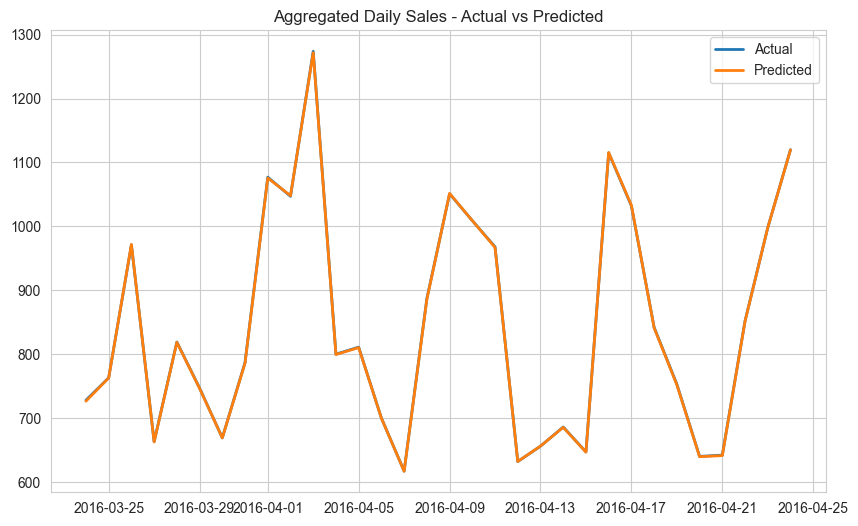

In [19]:
agg_actual = valid.groupby('date')['sales'].sum()
agg_pred = pd.Series(yhat, index=valid.index).groupby(valid['date']).sum()

plt.figure(figsize=(10, 6))
plt.plot(agg_actual.index, agg_actual.values, label='Actual', lw=2)
plt.plot(agg_pred.index, agg_pred.values, label = "Predicted", lw=2)
plt.title("Aggregated Daily Sales - Actual vs Predicted")
plt.legend()
plt.show()

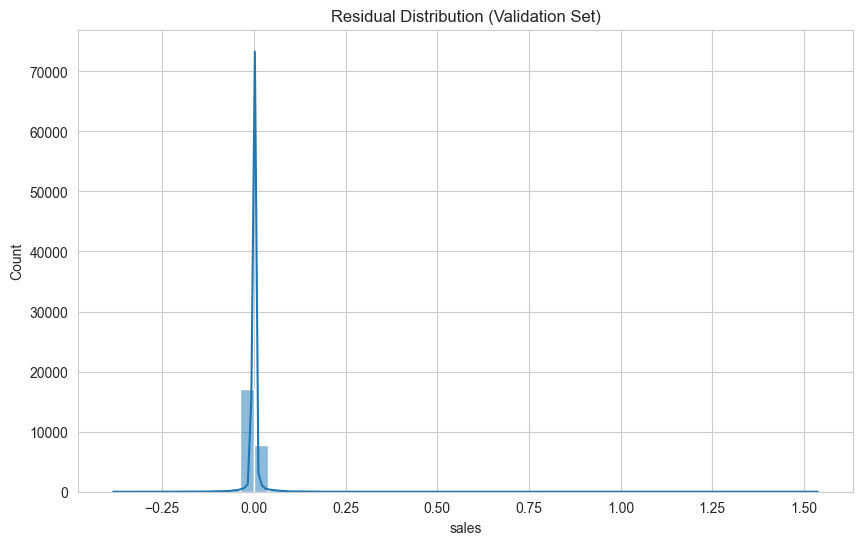

In [20]:
residuals = y_va - yhat
plt.figure(figsize=(10,6))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Residual Distribution (Validation Set)")
plt.show()

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(agg_actual, agg_pred)
rmse = np.sqrt(mean_squared_error(agg_actual, agg_pred))

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 0.63, RMSE: 0.79


In [22]:
pred_df = valid[['id', 'date']].copy()
pred_df['yhat'] = yhat
pred_df['sales'] = y_va.values
pred_df.to_parquet('../reports/predictions.parquet', index=False)